Smilegate.AI에서 배포한 `Unsmile`(https://github.com/smilegate-ai/korean_unsmile_dataset) 데이터셋을 이용해 언어 모델을 `classification task`로 fine-tuning하고, 훈련시킨 모델을 다른 혐오표현 데이터셋에 테스트해보는 __Cross-Dataset Testing__을 개인 프로젝트로 진행했습니다. 

최근 혐오표현 탐지에 관심이 모임에 따라 다양한 혐오표현 데이터셋이 발표되었지만, 데이터셋 간의 일반화 가능성(generalizability)을 보는 연구는 아직 수행된 바가 없습니다. 

이에 여기서는 cross-dataset training과 testing을 통해, Unsmile 데이터셋에 훈련된 모델이 "한국어 혐오표현 데이터셋(https://github.com/kocohub/korean-hate-speech)”과 “HateScore(https://github.com/sgunderscore/hatescore-korean-hate-speech)" 데이터셋을 어느 정도로 정확히 예측하는지 실험했습니다.

# 1. 준비

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow_addons

     |████████████████████████████████| 4.2 MB 33.9 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 88.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 34.2 MB/s 
     |████████████████████████████████| 1.1 MB 28.2 MB/s 


텐서플로우 2와 필요한 모듈들을 임포트합니다.  
최근에 텐서플로우 기본 버전은 2로 바뀌었습니다.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import logging

구글 드라이브와 Colab을 연동합니다.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/Mydrive/')

Mounted at /content/Mydrive/


딥러닝 훈련에 사용 할 train 데이터와 test 데이터를 pandas dataframe 형식으로 불러옵니다.
여기서는 'Beep!' 논문에서 배포한 한국어 혐오표현 데이터셋을 불러왔습니다. 

In [ ]:
data = pd.read_csv("/content/Unsmile-modified.tsv", sep = '\t')

data_x = data['문장'] #문장
data_y = data['hate'] #라벨

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                 stratify = data_y, 
                 test_size = 0.3,
                 random_state = 15)

train = pd.concat([X_train, y_train], axis=1).reset_index()
test = pd.concat([X_test, y_test], axis=1).reset_index()

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (10503, 3)
Test: (4502, 3)


In [ ]:
test

,index,문장,hate
0,8211,본네트가 간지네..,0
1,7773,둘다 병신,1
2,5784,"4월에 내용을 지금 리바이벌 하네, 기자라는게 자질이 없네",1
3,6569,똑똑이ㅋㅋㅋㅋ,0
4,5446,유흥중독인가.. 매니저하니까 직업이 그건줄,1
...,...,...,...
4497,13671,시발 이러다 한새끼 뒤져야 끝날껀가. ㅋㅋㅋㅋ,1
4498,7517,마더 빠커 좆양키 시발놈.... 개량한복 처입은 개새끼 면상 써는게 아니라 양키 똥...,1
4499,12945,으따 내가 시방 어제 지진이 와부러서 발목을 삐었당께 정부가 보상하랑께? 이런새끼들...,1
4500,10483,"개새끼, 소새끼, 씹새끼, 니애미, 니애비 이런 단순 욕설이 아니라눈깔 파버린다, ...",1


# 2. BERT input만들기

한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.  
이번에는 한국어 데이터로 훈련되었고, SKT에서 만든 KoBERT를 사용하도록 하겠습니다.  
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.  
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.  
https://github.com/monologg/KoBERT-NER 에서 kobert를 tokenize 할 수 있는 코드를 가져왔습니다.

In [ ]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

kobert 토크나이즈를 임포트합니다.

In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp8yp5xbow


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model in cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
creating metadata file for /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
https://huggingface.co/monologg/kobert/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprkh6ppbe


Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
creating metadata file for /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbmiaw4c_


Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
creating metadata file for /root/.cache/huggingface/transformers/d1c07e179f5e00959a3c8e4a150eaa4907dfe26544e4a71f2b0163982a476523.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1
loading file https://huggingface.co/monologg/kobert/resolve/main/tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/transformers/7e55d7972628e6fc1babc614b5dd8bb43ab4f9d8541adc9fb1851112a7a7c5cc.4d2f4af7c2ca9df5b147978a95d38840e84801a378eee25756b008638e0bdc7f
loading file https://huggingface.co/monologg/kobert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/efee434f5f4c5c89b5a7d8d5f30bbb0496f1540349fcfa21729cec5b96cfd2d1.719459e20bc981bc2093e859b02c3a3e51bab724d6b58927b23b512a3981229f
loading file

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
creating metadata file for /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,


In [ ]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(1 = 혐오표현,0 = 비혐오표현)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "문장"
# 긍정인지 부정인지를 (1 = 혐오표현,0 = 비혐오표현) 포함하고 있는 칼럼
LABEL_COLUMN = "hate"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 10503/10503 [00:02<00:00, 4397.86it/s]


In [ ]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 4502/4502 [00:00<00:00, 5083.40it/s]


# 2. BERT fine-tuning

In [ ]:
from transformers import BertTokenizer, TFBertModel

In [ ]:
model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_outputs = bert_outputs[1]
bert_outputs

loading configuration file https://huggingface.co/monologg/kobert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/31dc8da633439f22ed80bede01f337996bc709eb8429f86f2b24e2103558b039.89a06cdfd16840fd89cc5c2493ef63cd0b6068e85f70ac988a3673e2722cab2e
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

storing https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
creating metadata file for /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
loading weights file https://huggingface.co/monologg/kobert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
Loading PyTorch weights from /root/.cache/huggingface/transformers/9525d6f96682baa1f21538ea58d36263fe16a46345dd9637e3e28a4df2f9380f.ebe6e13ff204bebbffd4764cda3d5a97dc690a9c4110bde6d909ddc3ed5c4585
PyTorch checkpoint contains 92,186,880 parameters
Loaded 92,186,880 parameter

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [ ]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)

opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 3. 훈련 및 성능 검증

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)
sentiment_model.fit(train_x, train_y, epochs=5, shuffle=True, batch_size=32, callbacks=[es], validation_data=(test_x, test_y))

Epoch 1/5
329/329 [==============================] - 348s 973ms/step - loss: 0.5712 - accuracy: 0.7301 - val_loss: 0.5340 - val_accuracy: 0.7508
Epoch 2/5
329/329 [==============================] - 328s 998ms/step - loss: 0.4934 - accuracy: 0.7558 - val_loss: 0.4112 - val_accuracy: 0.7968
Epoch 3/5
329/329 [==============================] - 328s 998ms/step - loss: 0.3891 - accuracy: 0.8179 - val_loss: 0.3841 - val_accuracy: 0.8267
Epoch 4/5
329/329 [==============================] - 328s 998ms/step - loss: 0.3232 - accuracy: 0.8626 - val_loss: 0.3550 - val_accuracy: 0.8372
Epoch 5/5
329/329 [==============================] - 328s 997ms/step - loss: 0.2547 - accuracy: 0.8961 - val_loss: 0.3649 - val_accuracy: 0.8374


In [ ]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

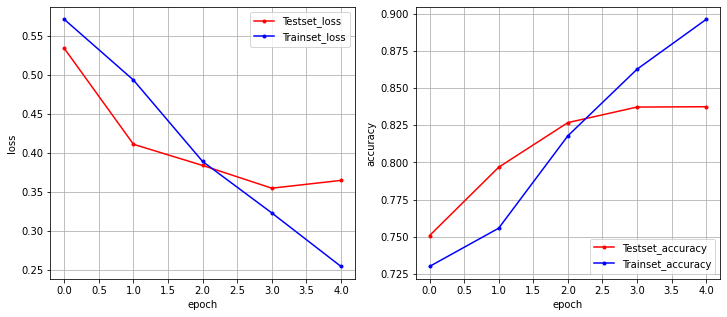

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# 오차
y_vloss = sentiment_model.history.history['val_loss']

# 학습셋 오차
y_loss = sentiment_model.history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss')


# 정확도
y_vaccuracy = sentiment_model.history.history['val_accuracy']

# 학습셋
y_accuracy = sentiment_model.history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

훈련 모델의 예측 성능을 F1 SCORE로 체크하기 위한 작업

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

# 각 지표 구하는 함수 구현
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    Specificity = cf_matrix[0][0] / (cf_matrix[0][0] + cf_matrix[0][1])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    
    print(f'Accuracy: {Accuracy}')
    print(f'Precision: {Precision}')
    print(f'Recall: {Recall}')
    print(f'Specificity: {Specificity}')
    print(f'F1_Score: {F1_Score}')

# 4. 모델 평가

In [ ]:
from transformers import TextClassificationPipeline


In [ ]:
test_df = pd.read_csv('/content/Mydrive/MyDrive/1129/tsv_Counter speech.tsv', sep = '\t')

predicted_label_list = []
predicted_score_list = []

for text in test_df['text']:
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
    predicted_label_list.append(sorted_preds_list[0]) # label
    predicted_score_list.append(sorted_preds_list[1]) # score

test 데이터 예측하기

In [ ]:
test2 = pd.read_csv('/content/Beep-modified.tsv', sep = '\t')
test2

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1
2,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1
3,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1
4,180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 ...,1
...,...,...
5392,힘내세요~ 응원합니다!!,0
5393,힘내세요~~삼가 고인의 명복을 빕니다..,0
5394,힘내세용 ^^ 항상 응원합니닷 ^^ !,0
5395,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,0


In [ ]:
test3 = pd.read_csv('/content/HateScore-modified.tsv', sep = '\t')
test3

,Unnamed: 0,comment,hate,microlabel,source
0,0,절라남도 벌레?,1,지역,온라인 댓글
1,1,부산에서 학식먹었는데 mt 동기mt 동아리mt 단한번도 해운대 안감 부산 현지인들이...,1,지역,온라인 댓글
2,2,쌍도 여혐끝판왕의성지,1,지역,온라인 댓글
3,3,제목보고 전라도 직감,1,지역,온라인 댓글
4,4,홍어지 병신아 ㅋㅋㅋ,1,지역,온라인 댓글
...,...,...,...,...,...
10951,11103,안녕하세요 이란에서 태어난 사람인가?,0,None,규칙 기반 생성
10952,11104,트랜스젠더인 거 같네,0,None,규칙 기반 생성
10953,11105,저 분은 리비아 친구 처음 만나네,0,None,규칙 기반 생성
10954,11106,쟤는 독일 사람 처음 만나네,0,None,규칙 기반 생성


In [ ]:
test2.rename(columns={'comments':'문장'}, inplace = True)
test2

,문장,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1
2,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1
3,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1
4,180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 ...,1
...,...,...
5392,힘내세요~ 응원합니다!!,0
5393,힘내세요~~삼가 고인의 명복을 빕니다..,0
5394,힘내세용 ^^ 항상 응원합니닷 ^^ !,0
5395,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,0


In [ ]:
test3.rename(columns={'comment':'문장'}, inplace = True)
test3

,Unnamed: 0,문장,hate,microlabel,source
0,0,절라남도 벌레?,1,지역,온라인 댓글
1,1,부산에서 학식먹었는데 mt 동기mt 동아리mt 단한번도 해운대 안감 부산 현지인들이...,1,지역,온라인 댓글
2,2,쌍도 여혐끝판왕의성지,1,지역,온라인 댓글
3,3,제목보고 전라도 직감,1,지역,온라인 댓글
4,4,홍어지 병신아 ㅋㅋㅋ,1,지역,온라인 댓글
...,...,...,...,...,...
10951,11103,안녕하세요 이란에서 태어난 사람인가?,0,None,규칙 기반 생성
10952,11104,트랜스젠더인 거 같네,0,None,규칙 기반 생성
10953,11105,저 분은 리비아 친구 처음 만나네,0,None,규칙 기반 생성
10954,11106,쟤는 독일 사람 처음 만나네,0,None,규칙 기반 생성


In [ ]:
#test2 = pd.read_csv('/content/Beep-modified.tsv', sep = '\t')
test_set = predict_load_data(test2)
proba = sentiment_model.predict(test_set)

test2['probability'] = proba
test2['pred'] = np.round(proba, 0)
test2

100%|██████████| 5397/5397 [00:01<00:00, 5017.42it/s]


,문장,hate,probability,pred
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1,0.212681,0.0
1,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1,0.857640,1.0
2,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,1,0.795280,1.0
3,"100년안에 남녀간 성전쟁 한번 크게 치룬 후 일부다처제, 여성의 정치참여 금지, ...",1,0.966753,1.0
4,180이하 호빗 한남들은 결혼 하지마셈 ㅋ 돈없으면 연애도 하지마셈 ㅋ 니들 호빗 ...,1,0.991673,1.0
...,...,...,...,...
5392,힘내세요~ 응원합니다!!,0,0.112939,0.0
5393,힘내세요~~삼가 고인의 명복을 빕니다..,0,0.599206,1.0
5394,힘내세용 ^^ 항상 응원합니닷 ^^ !,0,0.124905,0.0
5395,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,0,0.129653,0.0


In [ ]:
test_set = predict_load_data(test3)
proba = sentiment_model.predict(test_set)

test3['probability'] = proba
test3['pred'] = np.round(proba, 0)
test3

100%|██████████| 10956/10956 [00:01<00:00, 5619.53it/s]


,Unnamed: 0,문장,hate,microlabel,source,probability,pred
0,0,절라남도 벌레?,1,지역,온라인 댓글,0.934010,1.0
1,1,부산에서 학식먹었는데 mt 동기mt 동아리mt 단한번도 해운대 안감 부산 현지인들이...,1,지역,온라인 댓글,0.152343,0.0
2,2,쌍도 여혐끝판왕의성지,1,지역,온라인 댓글,0.991096,1.0
3,3,제목보고 전라도 직감,1,지역,온라인 댓글,0.960557,1.0
4,4,홍어지 병신아 ㅋㅋㅋ,1,지역,온라인 댓글,0.991658,1.0
...,...,...,...,...,...,...,...
10951,11103,안녕하세요 이란에서 태어난 사람인가?,0,None,규칙 기반 생성,0.229213,0.0
10952,11104,트랜스젠더인 거 같네,0,None,규칙 기반 생성,0.962163,1.0
10953,11105,저 분은 리비아 친구 처음 만나네,0,None,규칙 기반 생성,0.127884,0.0
10954,11106,쟤는 독일 사람 처음 만나네,0,None,규칙 기반 생성,0.305588,0.0


In [ ]:
# 예전 버전: 사고관련 --> 0을 출력
y_true = test2['hate']

model_evaluation(y_true, np.round(proba, 0))
confusion_matrix(y_true, np.round(proba, 0))

Accuracy: 0.7291087641282193
Precision: 0.5841769778777652
Recall: 0.815279958137101
Specificity: 0.6818703384968445
F1_Score: 0.6806465705548274


array([[2377, 1109],
       [ 353, 1558]])

In [ ]:
# Beep 데이터셋에다가 예측
y_true = test2['hate']
y_pred = test2['pred']

confusion = confusion_matrix(y_true, y_pred)
print(confusion)

[[2377 1109]
 [ 353 1558]]


In [ ]:
#HateScore 데이터셋에다가 예측
y_true = test3['hate']
y_pred = test3['pred']

model_evaluation(y_true, y_pred)

confusion = confusion_matrix(y_true, y_pred)
print(confusion)

Accuracy: 0.6379152975538518
Precision: 0.15935828877005348
Recall: 0.9526854219948849
Specificity: 0.6137212502457244
F1_Score: 0.2730437969580356
[[6244 3930]
 [  37  745]]


In [ ]:
import seaborn as sns 

In [ ]:
matrix = pd.DataFrame(confusion,
                     columns = ['Positive','Negative'],
                     index= ['True','False']
                     ) 

matrix

,Positive,Negative
True,6244,3930
False,37,745


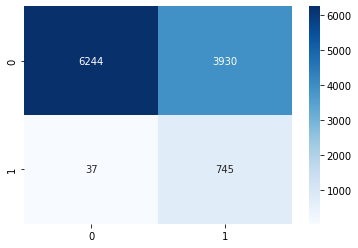

In [ ]:
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')

In [ ]:
test3.to_csv('./HateScore_predicted_by_Unsmile.csv')

In [ ]:
MODEL_NAME = 'Unsmile-fine-tuned-Kobert'
MODEL_SAVE_PATH = os.path.join("/content/drive/MyDrive/my model", MODEL_NAME) # change this to your preferred location

if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

/content/drive/MyDrive/my model/Unsmile-fine-tuned-Kobert -- Folder create complete 



In [ ]:
sentiment_model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/my model/Unsmile-fine-tuned-Kobert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/my model/Unsmile-fine-tuned-Kobert/assets


---